In [15]:
#import statements
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation,MaxPooling2D,Dropout,Flatten
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from keras import optimizers
from sklearn.ensemble import RandomForestRegressor
import os
from keras import backend as K
from keras.utils import plot_model

#df is data from csv file
filename_train_csv = "data/train_free_throws.csv"
df=pd.read_csv(filename_train_csv, header = None)

#change this csv for testing
filename_test_csv = "data/test_free_throws.csv"
mainDF=pd.read_csv(filename_test_csv, header = None)
datagen=ImageDataGenerator() #rescale=1./255)


df.columns = ['0','1']
mainDF.columns = ['0','1']


# main generator is the one for test data
main_generator=datagen.flow_from_dataframe(dataframe=mainDF, directory="data/", x_col="0",
                                           y_col="1", class_mode="raw", target_size=(320,180), batch_size=32)

valid_generator=datagen.flow_from_dataframe(dataframe=df, directory="data/", x_col="0",
                                           y_col="1", class_mode="raw", target_size=(320,180), batch_size=32)

Found 30000 validated image filenames.
Found 20000 validated image filenames.


In [16]:
model_kernel_size = (3,3)
input_shape=(320,180,3)
num_classes = 2  # True of False classification

model = Sequential()
model.add(Conv2D(6, kernel_size=model_kernel_size, activation='relu', input_shape= input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size= model_kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

In [3]:
def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [5]:
#model.compile(optimizers.rmsprop(lr=0.0001),loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizers.rmsprop(lr=0.0001),loss="sparse_categorical_crossentropy", 
              metrics=["accuracy", precision, recall])

STEP_SIZE_TRAIN = main_generator.n//main_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
hist = model.fit_generator(generator=main_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 1 )

#score = model.evalutate(x_test,y_test, verbose = 0)

# training values
#acc = hist.history['acc']
#loss_ = hist.history['loss']

#print("test accuracy: " , acc)

Epoch 1/1
937/937 [==============================] - 78s 83ms/step - loss: 0.0346 - accuracy: 0.9948 - precision: 0.1304 - recall: 0.9883 - val_loss: 2.9764 - val_accuracy: 0.9115 - val_precision: 0.0828 - val_recall: 0.9376


KeyError: 'acc'

In [7]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
#def inference(csv_file):
csv_file = 'data/test_free_throws.csv'
#load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#load weights into new model
loaded_model.load_weights("model.h5")
#... read csv file
# df is data from csv file
filename = csv_file
df=pd.read_csv(filename, header = None)
df.columns = ['0','1']
valid_generator = datagen.flow_from_dataframe(dataframe=df, directory="data/", x_col="0",y_col="1",
                                            class_mode="raw", target_size=(320,180), batch_size=32)


loaded_model.compile(optimizers.rmsprop(lr=0.0001),loss="sparse_categorical_crossentropy", 
              metrics=["accuracy", precision, recall])
#... use the model to do inference
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
score = loaded_model.evaluate_generator(generator = valid_generator, steps = STEP_SIZE_VALID,
                                 use_multiprocessing = False, verbose = 1 )

print('\n answer:\n')
print('Test loss:', score[0] )
print('Test accuracy:', score[1] )
print('Test recall:', score[2] )
print('Test precision:', score[3] )
print('\n')

#... compute accuracy,recall and precision score using 0.5 threshold
#return {'accuracy':accuracy, 'recall':recall, 'precision':precision}

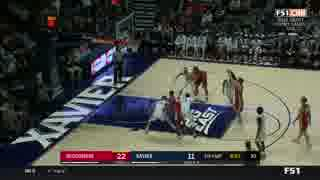

In [34]:
from IPython.display import Image, display
display(Image(filename='data/10031/jpg/320_180/thumb00110000.jpg'))

In [12]:
'''
heatmap_generator=datagen.flow_from_dataframe(dataframe=mainDF, directory="data/", x_col="0",
                                           y_col="1", classes = [1,0] ,class_mode=None, target_size=(180,320), batch_size=1)

x= heatmap_generator.next()

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict_generator(generator = valid_generator, steps = STEP_SIZE_VALID, verbose = 1 )#(X_train[10].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
'''

"\nfrom keras.models import Model\nlayer_outputs = [layer.output for layer in model.layers]\nactivation_model = Model(inputs=model.input, outputs=layer_outputs)\nactivations = activation_model.predict_generator(generator = valid_generator, steps = STEP_SIZE_VALID, verbose = 1 )#(X_train[10].reshape(1,28,28,1))\n \ndef display_activation(activations, col_size, row_size, act_index): \n    activation = activations[act_index]\n    activation_index=0\n    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))\n    for row in range(0,row_size):\n        for col in range(0,col_size):\n            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')\n            activation_index += 1\n"

In [13]:
#display_activation(activations, 8, 8, 1)

In [17]:
filename_train_csv = "data/free_throw_training_data.csv"
df=pd.read_csv(filename_train_csv, header = None)

cut = 30000
cut_end = cut + 20000
df1 = df.iloc[:cut, :]
df2 = df.iloc[cut:cut_end, :]
df1.shape, df2.shape

df1.to_csv("data/test_free_throws.csv", header= None, index=False)
df2.to_csv("data/train_free_throws.csv", header= None, index=False)

df1.shape, df2.shape

((30000, 2), (20000, 2))

In [61]:
from keras.models import model_from_json
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation,MaxPooling2D,Dropout,Flatten
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
#import numpy as np
from keras import optimizers
import os
from keras import backend as K
from PIL import Image
import sys

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


#def inference(csv_file):
#load json and create model
input_file = 'dunk_layup_test_data.csv'

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#load weights into new model
loaded_model.load_weights("model.h5")

#... read csv file
# df is data from csv file

df=pd.read_csv(input_file, header = None)
df.columns = ['0','1']
datagen=ImageDataGenerator() 
valid_generator = datagen.flow_from_dataframe(dataframe=df, directory="data/", x_col="0",y_col="1",
                                            class_mode="raw", target_size=(320,180), batch_size=30)

loaded_model.compile(optimizers.rmsprop(lr=0.0001),loss="sparse_categorical_crossentropy", 
          metrics=["accuracy", precision, recall])

print('evaluate model')
#... use the model to do inference
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

Found 16380 validated image filenames.
evaluate model


/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 14032 invalid image filename(s) in x_col="0". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [62]:
score = loaded_model.evaluate_generator(generator = valid_generator, steps = STEP_SIZE_VALID  )


# accuracy
accuracy_output = score[1]

# recall = truePositives / (truePositives + falseNegatives) backend.epislon()
recall_output = score[2]

# precision = truePositives / (truePositives + falsePositives)
precision_output = score[3]

#... compute accuracy,recall and precision score using 0.5 threshold
#return {'accuracy':accuracy_output, 'recall':recall_output, 'precision':precision_output}



#if __name__ == '__main__':
    #input_file = sys.argv[1] 

#ans = inference(input_file)
#print('done\n')
#print(ans)

KeyboardInterrupt: 